In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.1 MB/s eta 0:00:00


In [ ]:
import spacy
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import sent_tokenize, word_tokenize
import nltk
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import xgboost as xgb
from scipy.stats import zscore
import pandas as pd


nlp = spacy.load('en_core_web_sm')

In [ ]:
def load_and_preprocess_data(path):
    # Load the dataframe
    df = pd.read_csv(path)

    # Split the data into human and GPT datasets
    dfs = dict(tuple(df.groupby('label')))
    Human_df = dfs[0].reset_index(drop=True)
    GPT_df = dfs[1].reset_index(drop=True)

    return Human_df, GPT_df

def preprocess_dataframe(df):
    # Make a copy to avoid warnings and unintended modifications
    df_copy = df.copy()

    # Rename the column
    df_copy.rename(columns={"answer": "text"}, inplace=True)

    # Drop unwanted columns
    df_copy.drop(['id', 'question'], axis=1, inplace=True)

    # Filter out rows with less than 10 tokens
    df_copy = df_copy[df_copy['text'].str.split().str.len() >= 10]

    return df_copy

def split_train_val(df):
    # Sample 7000 rows for validation data
    df_val = df.sample(n=7000, random_state=42)

    # Remove these rows from the original data to avoid overlap
    df_train = df.drop(df_val.index).reset_index(drop=True)

    return df_train, df_val

# Load and preprocess data
Human_df_train, GPT_df_train = load_and_preprocess_data('/content/drive/MyDrive/HC3 - Unfiltered/en_train.csv')
Human_df_test, GPT_df_test = load_and_preprocess_data('/content/drive/MyDrive/HC3 - Unfiltered/en_test.csv')

# Split training data into training and validation
Human_df_train, Human_df_val = split_train_val(Human_df_train)
GPT_df_train, GPT_df_val = split_train_val(GPT_df_train)

# Preprocess dataframes
Human_df_train = preprocess_dataframe(Human_df_train)
GPT_df_train = preprocess_dataframe(GPT_df_train)
Human_df_val = preprocess_dataframe(Human_df_val)
GPT_df_val = preprocess_dataframe(GPT_df_val)
Human_df_test = preprocess_dataframe(Human_df_test)
GPT_df_test = preprocess_dataframe(GPT_df_test)

In [ ]:
# Add source columns
Human_df_train['source'] = 'train'
GPT_df_train['source'] = 'train'

Human_df_test['source'] = 'test'
GPT_df_test['source'] = 'test'



Human_df_val['source'] = 'val'
GPT_df_val['source'] = 'val'

# Concatenate all the datasets
GPT_df = pd.concat([GPT_df_train, GPT_df_test, GPT_df_val], ignore_index=True)
Human_df = pd.concat([Human_df_train, Human_df_test, Human_df_val], ignore_index=True)

In [ ]:
import re
from tqdm import tqdm
tqdm.pandas()

class TextPreprocessor:
    def __init__(self):
        # Compile regex patterns for performance
        self.space_before_punct = re.compile(r'\s+([.,?!;:])')
        self.space_after_punct = re.compile(r'([.,?!;:])\s+')
        self.contractions = re.compile(r"(\w) n\'t")
        self.double_dashes = re.compile(r"\s*--\s*")
        self.hyphens = re.compile(r"\s+-\s+")
        self.single_quotes_start = re.compile(r"(\w)'(\s)")
        self.single_quotes_end = re.compile(r"(\s)'(\w)")
        self.mentions = re.compile(r'(@.*?)[\s]')
        self.links = re.compile(r'https?:\/\/[^\s\n\r]+')
        self.embedded_quotes = re.compile(r'"\s([^"]+)\s"')
        self.single_quotes_embedded = re.compile(r"'\s([^']+)\s'")
        self.space_after_open_parenthesis = re.compile(r'\(\s')
        self.space_before_close_parenthesis = re.compile(r'\s\)')
        self.multi_spaces = re.compile(r'\s+')

    def preprocess(self, text):
        text = self.space_before_punct.sub(r'\1', text)
        text = self.space_after_punct.sub(r'\1 ', text)
        text = text.replace("\n", " ").replace("\\", "").replace('*', '')
        text = self.contractions.sub(r"\1n't", text)
        text = self.double_dashes.sub("--", text)
        text = self.hyphens.sub("-", text)
        text = self.single_quotes_start.sub(r"\1'", text)
        text = self.single_quotes_end.sub(r" '\1", text)
        text = self.mentions.sub(' ', text)
        text = self.links.sub(' ', text)
        text = text.replace('#', ' ').replace("&amp;", "&")
        text = self.embedded_quotes.sub(r'"\1"', text)
        text = self.single_quotes_embedded.sub(r"\1", text)
        text = self.space_after_open_parenthesis.sub('(', text)
        text = self.space_before_close_parenthesis.sub(')', text)
        text = self.multi_spaces.sub(' ', text)
        return text

preprocessor = TextPreprocessor()
GPT_df.text = GPT_df.text.progress_map(preprocessor.preprocess)
Human_df.text = Human_df.text.progress_map(preprocessor.preprocess)

100%|██████████| 55430/55430 [00:12<00:00, 4449.24it/s]


In [ ]:
def process_text(df):
    pos_list, dep_list = [], []
    total_words = 0
    all_ratios = []

    pos_tags = ['NOUN', 'PUNCT', 'VERB', 'ADP', 'DET', 'PRON', 'ADJ', 'AUX', 'ADV', 'CCONJ', 'PROPN', 'PART', 'SCONJ', 'NUM', 'SPACE', 'SYM', 'X', 'INTJ']
    dep_tags = ['punct', 'det', 'prep', 'pobj', 'nsubj', 'amod', 'dobj', 'aux', 'advmod', 'ROOT', 'conj', 'cc', 'compound', 'advcl', 'mark', 'ccomp', 'xcomp', 'relcl', 'acomp', 'attr', 'auxpass', 'poss', 'nsubjpass', 'neg', 'pcomp', 'nummod', 'acl', 'appos', 'prt', 'npadvmod']

    for doc in tqdm(nlp.pipe(df['text'].values, batch_size=2000)):
        pos_list.extend([token.pos_ for token in doc])
        dep_list.extend([token.dep_ for token in doc])

        pos_counts = defaultdict(int, {pos_tag: 0 for pos_tag in pos_tags})
        dep_counts = defaultdict(int, {dep_tag: 0 for dep_tag in dep_tags})

        for token in doc:
            pos_counts[token.pos_] += 1
            dep_counts[token.dep_] += 1

        total_tokens = len(doc)
        pos_ratios = {f'pos_{pos}': count/total_tokens for pos, count in pos_counts.items()}
        dep_ratios = {f'dep_{dep}': count/total_tokens for dep, count in dep_counts.items()}
        all_ratios.append({**pos_ratios, **dep_ratios})

        total_words += len(doc)

    pos_counts = Counter(pos_list)
    normalized_pos_counts = {k: v / total_words for k, v in pos_counts.items()}

    dep_counts = Counter(dep_list)
    normalized_dep_counts = {k: v / total_words for k, v in dep_counts.items()}

    return normalized_pos_counts, normalized_dep_counts, all_ratios

# Get results for GPT_df
pos_counts_GPT, dep_counts_GPT, ratios_GPT = process_text(GPT_df)
ratios_df_GPT = pd.DataFrame(ratios_GPT)
GPT_df = pd.concat([GPT_df, ratios_df_GPT], axis=1)

# Get results for Human_df
pos_counts_Human, dep_counts_Human, ratios_Human = process_text(Human_df)
ratios_df_Human = pd.DataFrame(ratios_Human)
Human_df = pd.concat([Human_df, ratios_df_Human], axis=1)

26760it [10:33, 42.25it/s]
55430it [15:29, 59.64it/s]


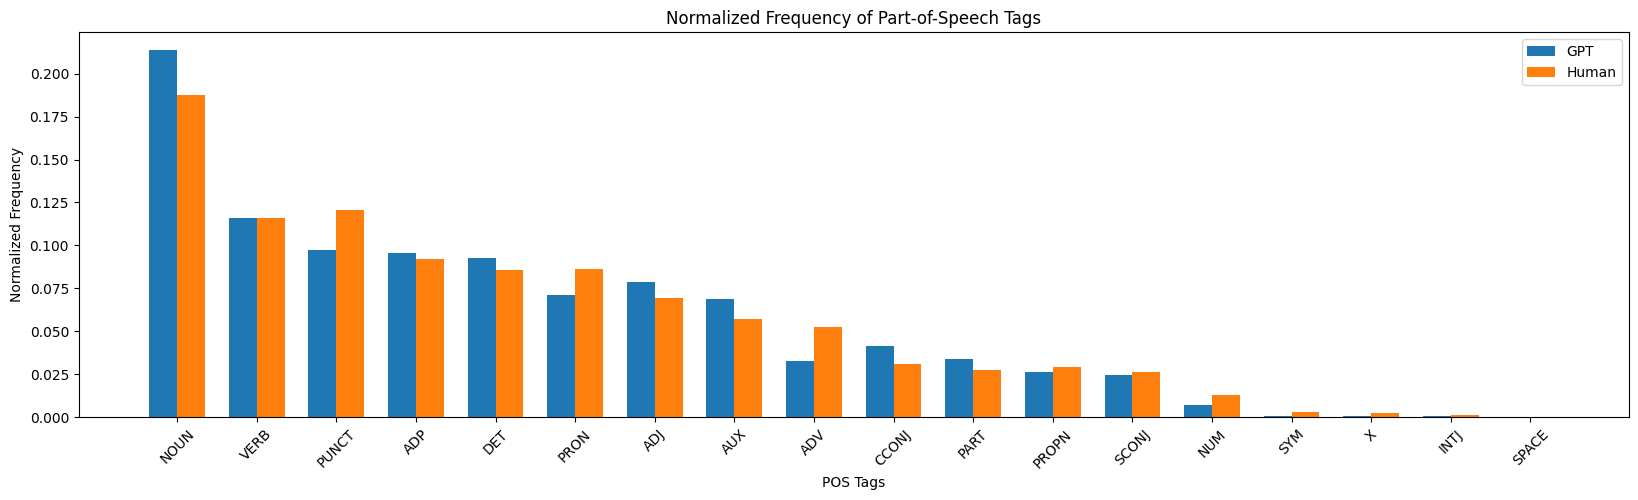

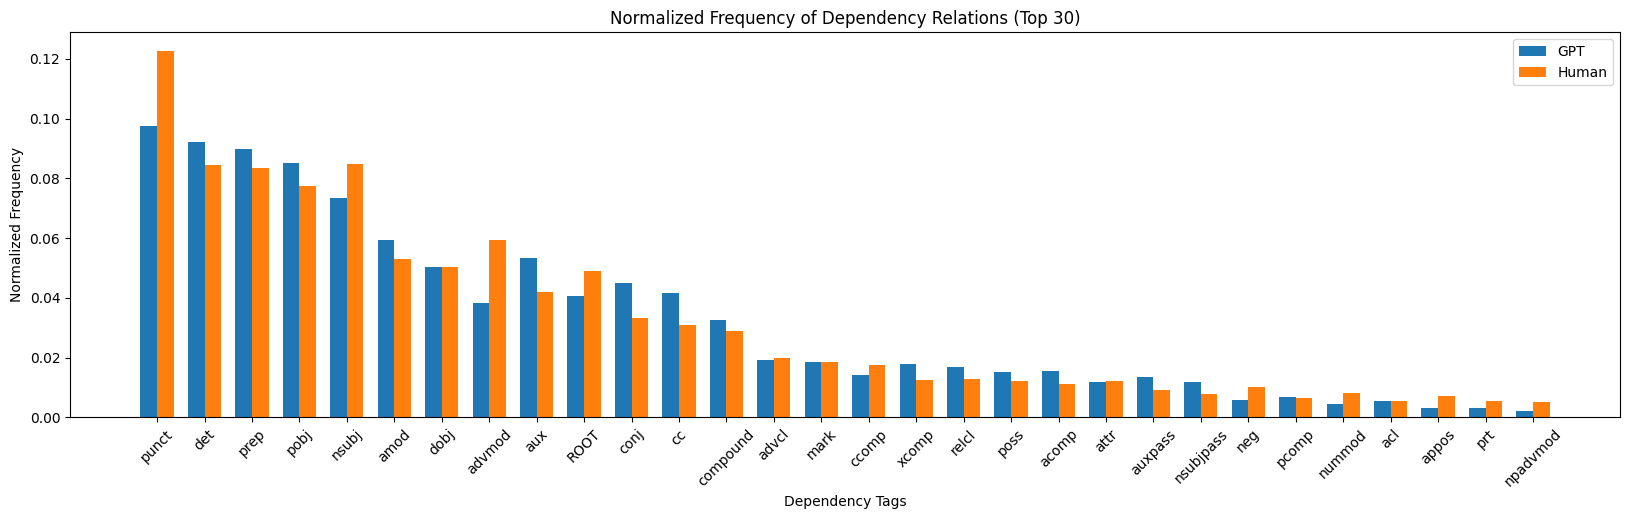

In [ ]:
def plot_data(labels, gpt_vals, human_vals, xlabel, title):
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.bar(x - width/2, gpt_vals, width, label='GPT')
    ax.bar(x + width/2, human_vals, width, label='Human')
    ax.set_ylabel('Normalized Frequency')
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()
    plt.show()

# Using the results from our earlier optimized function for plotting


# For POS tags
ud_tags = ['NOUN', 'PUNCT', 'VERB', 'ADP', 'DET', 'PRON', 'ADJ', 'AUX', 'ADV', 'CCONJ', 'PROPN', 'PART', 'SCONJ', 'NUM', 'SPACE', 'SYM', 'X', 'INTJ']

labels = ud_tags
gpt_vals = [pos_counts_GPT.get(key, 0) for key in labels]
human_vals = [pos_counts_Human.get(key, 0) for key in labels]

# Combined frequencies for sorting
combined_vals = [a+b for a, b in zip(gpt_vals, human_vals)]
combined, labels, gpt_vals, human_vals = zip(*sorted(zip(combined_vals, labels, gpt_vals, human_vals), reverse=True))

plot_data(labels, gpt_vals, human_vals, 'POS Tags', 'Normalized Frequency of Part-of-Speech Tags')

# For Dependency tags
combined_counts = Counter(dep_counts_GPT) + Counter(dep_counts_Human)
common_keys, _ = zip(*combined_counts.most_common(30))

gpt_vals = [dep_counts_GPT.get(key, 0) for key in common_keys]
human_vals = [dep_counts_Human.get(key, 0) for key in common_keys]

plot_data(common_keys, gpt_vals, human_vals, 'Dependency Tags', 'Normalized Frequency of Dependency Relations (Top 30)')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import gc
gc.collect()

16093

In [ ]:
#GPT_df.to_hdf("/content/drive/MyDrive/HC3 - Unfiltered/GPT_df_3.h5",key='GPT_df', mode='w')
#Human_df.to_hdf("/content/drive/MyDrive/HC3 - Unfiltered/Human_df_3.h5",key='Human_df', mode='w')

In [ ]:
GPT_df = pd.read_hdf("/content/drive/MyDrive/HC3 - Unfiltered/GPT_df_3.h5")
Human_df = pd.read_hdf("/content/drive/MyDrive/HC3 - Unfiltered/Human_df_3.h5")

In [ ]:

# Perplexity calculation functions
model = GPT2LMHeadModel.from_pretrained('gpt2').eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def batch_perplexity(sentences):
    tokenize_input = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    tokenize_input = {k: v.to(device) for k, v in tokenize_input.items()}
    loss = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        outputs = model(**tokenize_input, labels=tokenize_input["input_ids"])
        total_loss = loss(outputs.logits.view(-1, outputs.logits.size(-1)), tokenize_input["input_ids"].view(-1))
    return torch.exp(total_loss).item()

def avg_std_var_perplexity(text, batch_size=1000):
    sentences = sent_tokenize(text)
    data_loader = DataLoader(sentences, batch_size=batch_size)
    perp_values = [batch_perplexity(list(batch)) for batch in data_loader]
    return np.mean(perp_values), np.std(perp_values), np.var(perp_values)

# Apply average, standard deviation, and variance perplexity on answer column
for dataframe in [Human_df,GPT_df]:
    results = []
    # Add progress bar for dataframe processing
    for text in tqdm(dataframe['text'], desc="Processing DataFrames"):
        results.append(avg_std_var_perplexity(text))
    dataframe['avg_perplexity'], dataframe['std_perplexity'], dataframe['var_perplexity'] = zip(*results)


Using pad_token, but it is not set yet.
Processing DataFrames: 100%|██████████| 26760/26760 [08:07<00:00, 54.86it/s]


In [ ]:
# Function to calculate lexical diversity
def lexical_diversity(text):
    words = word_tokenize(text)
    unique_words = set(words)
    return len(unique_words) / len(words) if len(words) > 0 else 0


# Function to calculate average sentence length
def avg_and_std_sentence_length(text):
    sentences = sent_tokenize(text)
    lengths = [len(s.split()) for s in sentences]
    return np.mean(lengths), np.std(lengths)


def fano_factor(text):
    word_list = text.split()
    frequency = [word_list.count(w) for w in word_list]
    mean_freq = np.mean(frequency)
    var_freq = np.var(frequency)
    if mean_freq != 0:
        fano_val = var_freq / mean_freq
    else:
        fano_val = 0
    return fano_val


def sentence_complexity(text):
    clause_markers = ['and', 'or', 'but', 'because', 'if', 'while', 'although', 'though', 'unless', 'since', 'once']
    sentences = sent_tokenize(text)
    total_clauses = 0

    for sentence in sentences:
        tokenized_sentence = word_tokenize(sentence)
        # We add 1 to account for the main clause in every sentence
        total_clauses += sum(1 for word in tokenized_sentence if word in clause_markers) + 1

    return total_clauses / len(sentences) if sentences else 0

# Calculate word document frequency
all_text = pd.concat([GPT_df['text'], Human_df['text']])
all_documents = all_text.apply(lambda x: set(x.split())).tolist()
all_words = [word for document in all_documents for word in document]
word_document_frequency = Counter(all_words)
total_documents = len(all_documents)

# Apply the functions on answer column
for df in [GPT_df, Human_df]:
    df['lexical_diversity'] = df['text'].apply(lexical_diversity)
    df['fano_factor'] = df['text'].apply(lambda x:fano_factor(x))

GPT_df['avg_sentence_length'], GPT_df['std_sentence_length'] = zip(*GPT_df['text'].apply(avg_and_std_sentence_length))
Human_df['avg_sentence_length'], Human_df['std_sentence_length'] = zip(*Human_df['text'].apply(avg_and_std_sentence_length))
GPT_df['sentence_complexity'] = GPT_df['text'].apply(sentence_complexity)
Human_df['sentence_complexity'] = Human_df['text'].apply(sentence_complexity)

In [ ]:
GPT_df = GPT_df.fillna(0)
Human_df = Human_df.fillna(0)

In [ ]:
GPT_df.to_hdf("/content/drive/MyDrive/HC3 - Unfiltered/GPT_df_3.h5",key='GPT_df', mode='w')
Human_df.to_hdf("/content/drive/MyDrive/HC3 - Unfiltered/Human_df_3.h5",key='Human_df', mode='w')

In [ ]:
import pandas as pd
#GPT_df = pd.read_hdf("/content/drive/MyDrive/GPT_df_3.h5")
#Human_df = pd.read_hdf("/content/drive/MyDrive/Human_df_3.h5")

In [ ]:
#GPT_df.to_hdf("/content/drive/MyDrive/GPT_df_3.h5",key='GPT_df', mode='w')
#Human_df.to_hdf("/content/drive/MyDrive/Human_df_3.h5",key='Human_df', mode='w')

In [ ]:
# Remove outliers based on z-score
def remove_outliers(df, column_names, threshold=3):
    outliers = np.zeros(df.shape[0], dtype=bool)
    for col in column_names:
        z_scores = zscore(df[col].dropna())  # calculate z-scores
        outliers = outliers | (np.abs(z_scores) > threshold)  # identify outliers
    return df[~outliers]  # only keep rows that are not outliers

columns = GPT_df.drop(['label', 'text','source'], axis=1).columns
GPT_df_without_outliers = remove_outliers(GPT_df.dropna(), columns)
Human_df_without_outliers = remove_outliers(Human_df.dropna(), columns)

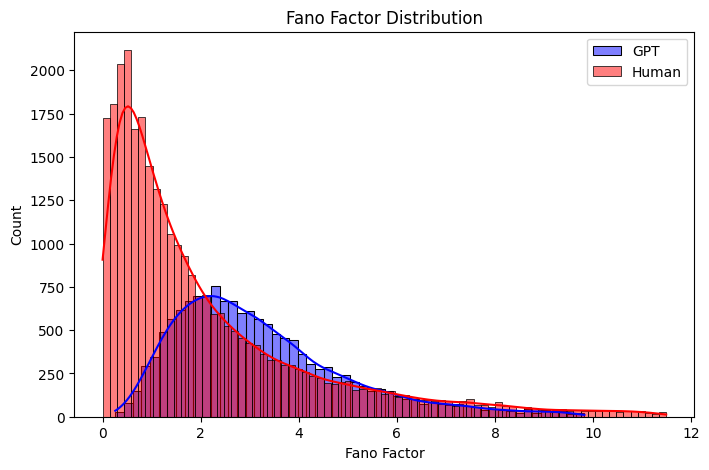

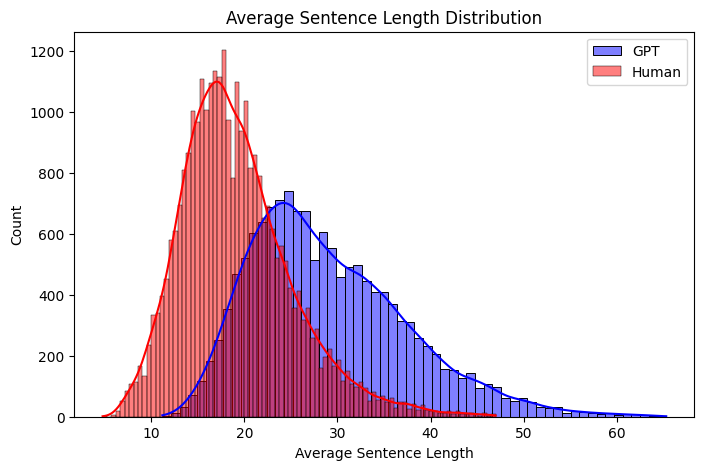

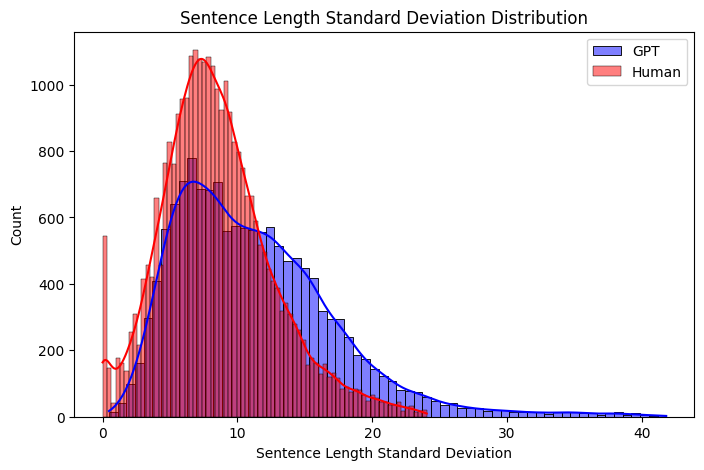

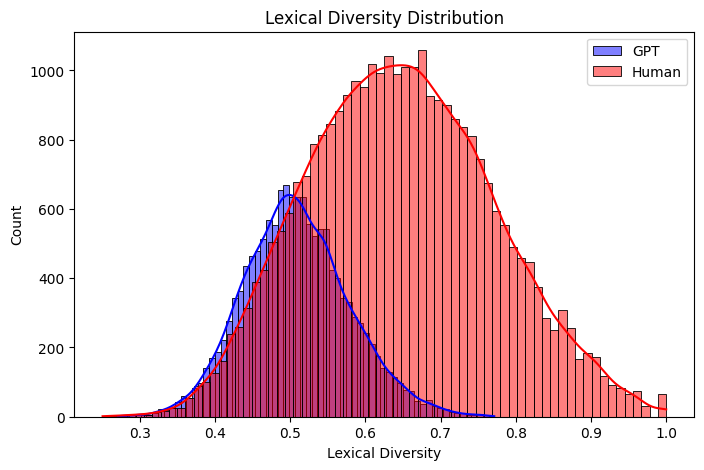

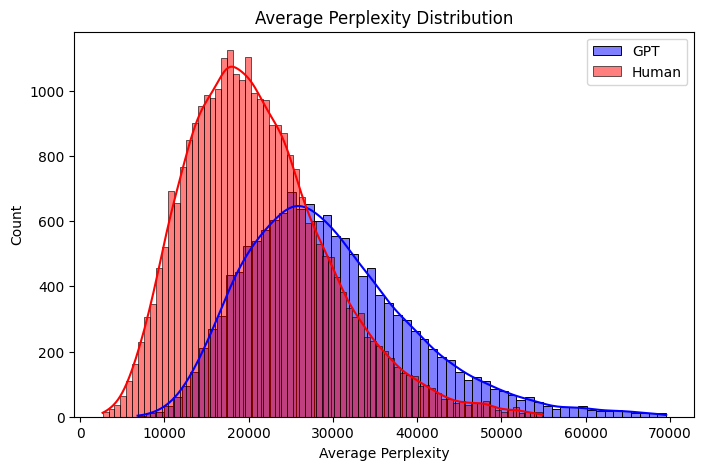

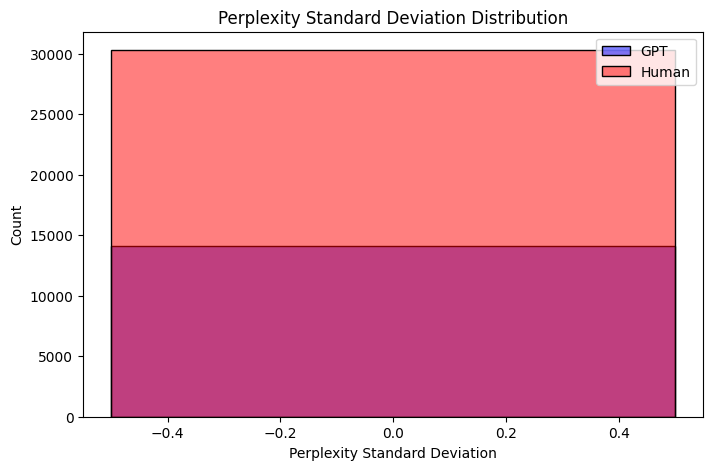

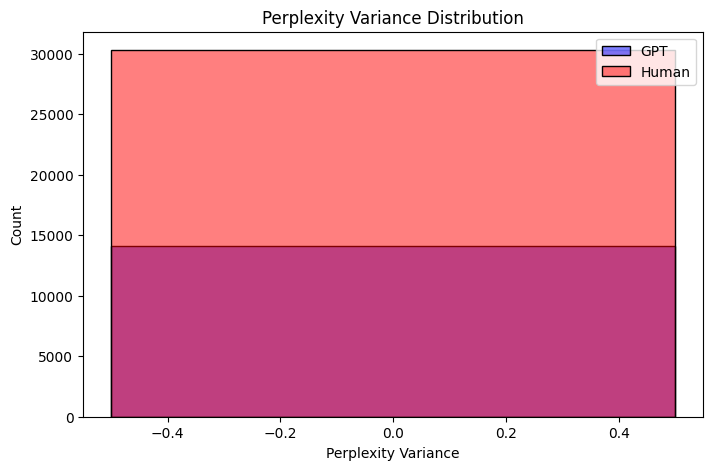

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of features
def plot_distribution(df1, df2, column, title, xlabel):
    plt.figure(figsize=(8, 5))
    sns.histplot(df1[column], color='blue', kde=True, label='GPT')
    sns.histplot(df2[column], color='red', kde=True, label='Human')
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

features_to_plot = [
    ('fano_factor', 'Fano Factor Distribution', 'Fano Factor'),
    ('avg_sentence_length', 'Average Sentence Length Distribution', 'Average Sentence Length'),
    ('std_sentence_length', 'Sentence Length Standard Deviation Distribution', 'Sentence Length Standard Deviation'),
    ('lexical_diversity', 'Lexical Diversity Distribution', 'Lexical Diversity'),
    ('avg_perplexity', 'Average Perplexity Distribution', 'Average Perplexity'),
    ('std_perplexity', 'Perplexity Standard Deviation Distribution', 'Perplexity Standard Deviation'),
    ('var_perplexity', 'Perplexity Variance Distribution', 'Perplexity Variance')
]

for feature, title, xlabel in features_to_plot:
    plot_distribution(GPT_df_without_outliers, Human_df_without_outliers, feature, title, xlabel)

[0]	validation_0-error:0.08762	validation_1-error:0.13474
[1]	validation_0-error:0.08097	validation_1-error:0.12831
[2]	validation_0-error:0.07364	validation_1-error:0.11777
[3]	validation_0-error:0.06731	validation_1-error:0.10852
[4]	validation_0-error:0.06306	validation_1-error:0.10259
[5]	validation_0-error:0.05944	validation_1-error:0.09833
[6]	validation_0-error:0.05810	validation_1-error:0.09559
[7]	validation_0-error:0.05387	validation_1-error:0.09125
[8]	validation_0-error:0.05106	validation_1-error:0.08735
[9]	validation_0-error:0.04909	validation_1-error:0.08511
[10]	validation_0-error:0.04598	validation_1-error:0.08150
[11]	validation_0-error:0.04301	validation_1-error:0.07940
[12]	validation_0-error:0.04128	validation_1-error:0.07601
[13]	validation_0-error:0.03945	validation_1-error:0.07550
[14]	validation_0-error:0.03890	validation_1-error:0.07333
[15]	validation_0-error:0.03684	validation_1-error:0.07268
[16]	validation_0-error:0.03545	validation_1-error:0.07001
[17]	va

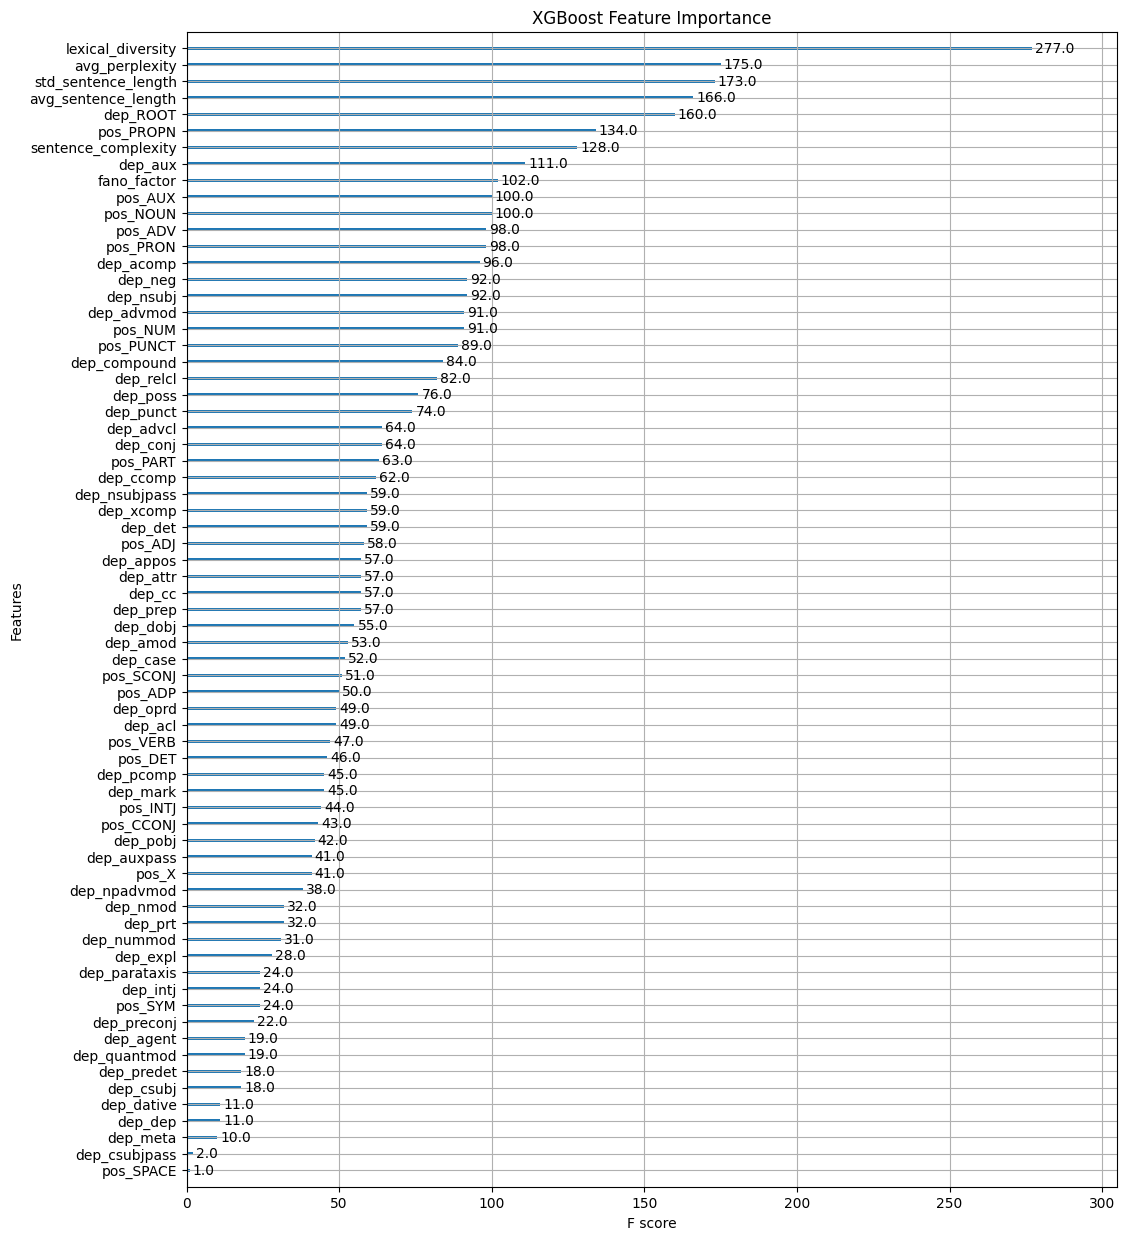

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Concatenate the two dataframes for ease of operation
combined_df = pd.concat([Human_df, GPT_df])

# Create datasets based on the 'source' column
X_train = combined_df[combined_df['source'].isin(['train'])].drop(['source','text'], axis=1)
y_train = X_train.pop('label')

X_test = combined_df[combined_df['source'].isin(['test'])].drop(['source','text'], axis=1)
y_test = X_test.pop('label')


X_val = combined_df[combined_df['source'].isin(['val'])].drop(['source','text'], axis=1)
y_val = X_val.pop('label')

clf = xgb.XGBClassifier(eval_metric="error", early_stopping_rounds=15)
evals = [(X_train, y_train), (X_val, y_val)]
clf.fit(X_train, y_train, eval_set=evals, verbose=True)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12, 15))
xgb.plot_importance(clf, ax=ax, importance_type='weight', title="XGBoost Feature Importance")
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.show()